In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

plt.rcParams['figure.figsize'] = [12, 6]

import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

from data_views import get_trip_and_history_tables

# Data Prep

In [2]:
trip_features, leg_history = get_trip_and_history_tables()
trip_features.head()

,current_time,headway,monday,tuesday,wednesday,thursday,friday,saturday,sunday,to_target
half_trip_id,,,,,,,,,,
41926539.0,29209,988.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,319
41926541.0,34603,1430.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,443
41926543.0,40696,2281.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,361
41926545.0,47240,1268.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,487
41926547.0,53741,952.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,309


In [3]:
leg_history.head()

,to_maput,to_cntsq,to_mit,to_hynes,to_masta
half_trip_id,,,,,
41926539.0,181,176,173,161,130
41926541.0,289,220,288,275,352
41926543.0,419,279,230,277,168
41926545.0,303,232,262,322,232
41926547.0,364,157,245,258,269


In [4]:
target_col = "to_target"

trip_train = trip_features.sample(frac=.7)
trip_test = trip_features.loc[~trip_features.index.isin(trip_train.index)]

y_train = trip_train.pop(target_col).to_numpy().astype('float32')
y_test = trip_test.pop(target_col).to_numpy().astype('float32')

x_trip_train = trip_train.to_numpy().astype('float32')
x_trip_test = trip_test.to_numpy().astype('float32')

In [5]:
def get_normalizer(data):
    means = data.mean(axis=0)
    std = data.std(axis=0)
    return lambda d: (d-means) / std

normalizer = get_normalizer(x_trip_train)
x_trip_train = normalizer(x_trip_train)
x_trip_test = normalizer(x_trip_test)

In [6]:
leg_history_np = leg_history.to_numpy()

# normalize values
leg_history_np = (leg_history_np - leg_history_np.mean()) / leg_history_np.std()

leg_history_train = leg_history_np[trip_features.index.isin(trip_train.index)]
leg_history_test = leg_history_np[~trip_features.index.isin(trip_train.index)]

def truncate_and_reshape(h):
    truncated_length = random.randint(1, len(h))
    one_hot = lambda v: [int(i==v) for i in range(len(h))]
    return torch.FloatTensor([[h[i]]+one_hot(i) for i in range(truncated_length)])

def process_leg_history(leg_history):
    """
    Input: 2d numpy array
    Output: 3d ragged tensor with shape [# datapoints, (len history), 2]
    """
    list_of_tensors = [truncate_and_reshape(h) for h in leg_history]
    lengths = [len(t) for t in list_of_tensors]
    return pad_sequence(list_of_tensors, batch_first=True), lengths

hist_train, hist_lengths_train = process_leg_history(leg_history_train)
hist_test, hist_lengths_test = process_leg_history(leg_history_test)

In [7]:
train = data.TensorDataset(
    torch.from_numpy(x_trip_train),
    hist_train,
    torch.LongTensor(hist_lengths_train),
    torch.from_numpy(y_train).reshape(-1, 1)
)

test = data.TensorDataset(
    torch.from_numpy(x_trip_test),
    hist_test,
    torch.LongTensor(hist_lengths_test),
    torch.from_numpy(y_test).reshape(-1, 1)
)

train_dl = data.DataLoader(train, batch_size=16, shuffle=True)
test_dl = data.DataLoader(test, batch_size=16)

In [15]:
train[0]

(tensor([ 9.4482e-01,  1.4277e-03, -4.2785e-01, -4.3962e-01, -4.2333e-01,
         -4.2532e-01, -4.2908e-01,  2.5915e+00, -3.2033e-01]),
 tensor([[-1.2547,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [-1.2946,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000],
         [-1.3185,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000],
         [-1.4143,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000]]),
 tensor(4),
 tensor([380.]))

# Experiments

In [8]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.hist_input_size = 6
        self.trip_input_size = 9
        self.lstm_output_size = 3
        
        self.lstm = nn.LSTM(self.hist_input_size, self.lstm_output_size, batch_first=True)
        self.fc1 = nn.Linear(self.lstm_output_size + self.trip_input_size, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 16)
        self.fc4 = nn.Linear(16, 1)
        
        self.dropout = nn.Dropout()
        
    def last_timestep(self, unpacked, lengths):
        # Index of the last output for each sequence.
        idx = ((lengths) - 1).view(-1, 1).expand(unpacked.size(0),
                                               unpacked.size(2)).unsqueeze(1)
        return unpacked.gather(1, idx).squeeze()

    def forward(self, trip, hist, hist_lengths):
        hist_packed = pack_padded_sequence(hist, batch_first=True, lengths = hist_lengths, enforce_sorted=False)
        hist_out_packed, _ = self.lstm(hist_packed)
        out_unpacked, _ = pad_packed_sequence(hist_out_packed, batch_first=True)
        hist_out = self.last_timestep(out_unpacked, hist_lengths)
        
        x = torch.cat([hist_out, trip], axis=1)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        return x

net = Net()
print(net)

Net(
  (lstm): LSTM(6, 3, batch_first=True)
  (fc1): Linear(in_features=12, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=16, bias=True)
  (fc4): Linear(in_features=16, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [9]:
model = Net()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_func = nn.MSELoss()

epochs = 50
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for trip, hist, hist_lengths, y in train_dl:
        pred = model(trip, hist, hist_lengths)
        loss = loss_func(pred, y)

        loss.backward()
        opt.step()
        opt.zero_grad()
        
        total_loss += loss

    train_loss = (total_loss / len(train_dl)).item()
    
    model.eval()
    with torch.no_grad():
        total_losses = sum(loss_func(model(trip, hist, hist_lens), y) for trip, hist, hist_lens, y in test_dl)
        valid_loss = (total_losses / len(test_dl)).item()

    print(f"Epoch {epoch}:\t training loss: {train_loss:,}\t test loss: {valid_loss:,}")

Epoch 0:	 training loss: 115,591.71875	 test loss: 71,588.8515625
Epoch 1:	 training loss: 84,334.734375	 test loss: 67,307.0859375
Epoch 2:	 training loss: 82,600.453125	 test loss: 64,944.10546875
Epoch 3:	 training loss: 81,238.1953125	 test loss: 63,515.83203125
Epoch 4:	 training loss: 79,227.59375	 test loss: 61,030.203125
Epoch 5:	 training loss: 76,686.9375	 test loss: 56,455.71875
Epoch 6:	 training loss: 74,802.40625	 test loss: 58,334.171875
Epoch 7:	 training loss: 73,803.453125	 test loss: 57,008.09375
Epoch 8:	 training loss: 72,739.9921875	 test loss: 56,804.50390625
Epoch 9:	 training loss: 71,903.53125	 test loss: 55,926.8828125
Epoch 10:	 training loss: 70,980.4921875	 test loss: 54,634.140625
Epoch 11:	 training loss: 69,545.3671875	 test loss: 54,911.6328125
Epoch 12:	 training loss: 68,253.40625	 test loss: 54,659.96875
Epoch 13:	 training loss: 68,591.671875	 test loss: 53,838.80859375
Epoch 14:	 training loss: 67,662.6875	 test loss: 54,961.71484375
Epoch 15:	 tr

In [10]:
trips = []
preds = []
durations = []
hist_lengths = []
with torch.no_grad():
    for trip, hist, hist_lens, y in test_dl:
        pred = model(trip, hist, hist_lens)
        trips.append(trip)
        preds.append(pred)
        hist_lengths.append(hist_lens)
        durations.append(y)
trips = torch.cat(trips)
preds = torch.cat(preds)
hist_lengths = torch.cat(hist_lengths)
durations = torch.cat(durations)

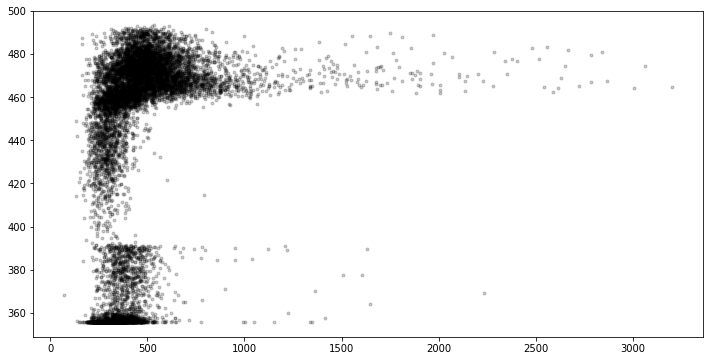

In [11]:
plt.plot(durations, preds, ".k", alpha=.2)

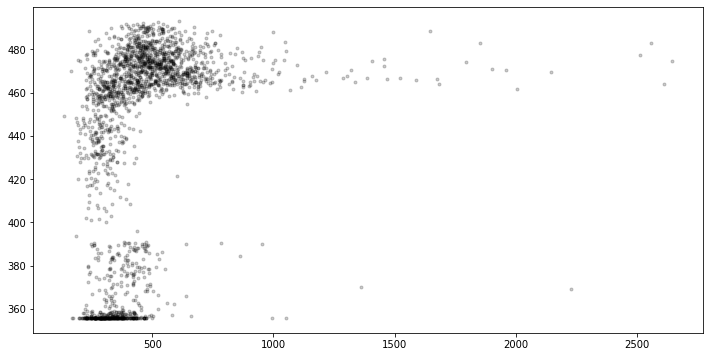

In [12]:
plt.plot(durations[hist_lengths==1], preds[hist_lengths==1], ".k", alpha=.2)

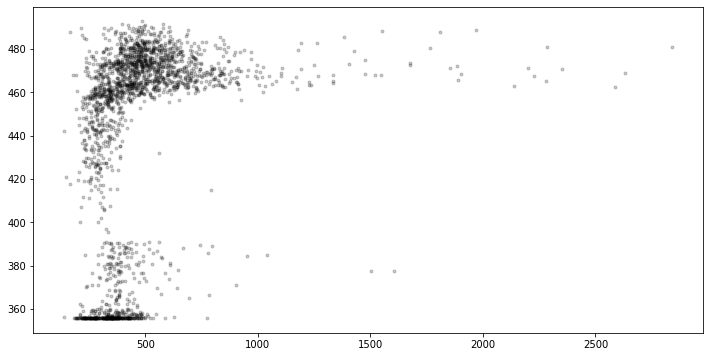

In [13]:
plt.plot(durations[hist_lengths==5], preds[hist_lengths==5], ".k", alpha=.2)